In [1]:
import pandas as pd 
import numpy as np
import hashlib
from csv import reader
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

In [2]:
def hash_str(to_hash): 
    stringToHash = to_hash.encode()
    return hashlib.sha256(stringToHash).hexdigest()

In [3]:
def process_lbl(line_list, filename): 
    data_list = []
    i = 0
    name_line = ''
    while (i < len(line_list)): 
        if i+1 < len(line_list) and '---------,---------,---------,---------' in line_list[i+1]:
            name_line = line_list[i].strip('\n')     
        elif "---------,---------,---------,---------" in line_list[i]: 
            pass
        else: 
            for line in reader([filename+','+name_line+','+line_list[i].strip()]):
                data_list.append(line)
        i = i + 1
    return data_list        

In [4]:
fig5_file= open("fig5_shell", "r")
fig5 = '\n'.join([x for x in fig5_file])
fig5_file.close()

overall_file= open("overall_table_shell", "r")
overall = '\n'.join([x for x in overall_file])
overall_file.close()

constraint_file= open("constraint_table_shell", "r")
constraint = '\n'.join([x for x in constraint_file])
constraint_file.close()

In [5]:
data = []
directory = 'tests/results'
 
# iterate over files in
# that directory
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if 'Data' not in filename and 'DS_Store' not in filename and os.path.isfile(filepath):
        print(filepath)
        f = open(filepath, "r")
        lbl = [x for x in f]
        f.close()
        data.extend(process_lbl(lbl,filename))

tests/results/brca1_var2_nonmatch1
tests/results/brca1_var1_nonmatch2
tests/results/brca2_var1_match
tests/results/brca1_var1_match
tests/results/brca1_var2_nonmatch2
tests/results/good_pass
tests/results/bad_pass
tests/results/brca1_var2_match
tests/results/brca1_var1_nonmatch1
tests/results/email_dkim
tests/results/pihole
tests/results/brca2_var1_nonmatch


In [6]:
df = pd.DataFrame(data, columns = ['app','doc','setup','time','regex','n_transitions','n_states',
                                    'test_type','component','test','val','metric'])
num_cols = ['time','n_transitions','n_states','val']
df[num_cols] = df[num_cols].apply(pd.to_numeric,errors='coerce', axis=1)

naive_sub = df.loc[(df.setup=='naive') 
       & (df.test.isin(['witness_generation','prove_0']))
      ].groupby(['time', 'regex','app','doc','setup','n_transitions','n_states','test_type']).sum().reset_index()
naive_sub['metric']='μs'
naive_sub['component'] = 'T'
naive_sub['test'] = 'prove+wit'
df = pd.concat([df,naive_sub])
df['hash_id'] = df.apply(lambda x: hash_str(x.doc+x.regex+x.app)[:5], axis=1)
df.loc[df.test=='prove+wit','component'] = 'T'
df.reset_index(inplace=True)

In [7]:
def create_timings_row(setup, hash_id, df): 
    sub = df.loc[
    (df.setup==setup) & 
    (df.hash_id==hash_id)
    & (df.component!='T')][['time','test_type','n_transitions','n_states','component','test','val','hash_id']]
    
    sub_time = sub.loc[sub.test_type=='R']
    
    time_data = pd.DataFrame(
        sub_time.groupby(by=['time','component']).sum().reset_index().groupby(by=['component']).val.mean()/1e6
    ).transpose().reset_index()

    r1cs_constraints = sub.loc[(sub.test_type=='NOC') & (sub.test=='step_circuit')].val.unique()[0]

    n_transitions = sub.n_transitions.unique()[0]
    n_states = sub.n_states.unique()[0]

    n_steps = sub_time.loc[sub_time.test.str.contains('prove_')].test.nunique()

    size = sub.loc[(sub.test_type=='S')].groupby(by=['time']).sum().reset_index().val.unique()[0]/1e3
    
    time_data['const'] = r1cs_constraints
    time_data['ns'] = n_states
    time_data['nt'] = n_transitions
    time_data['steps'] = n_steps
    time_data['size'] = size
    time_data['C'] = time_data['C'] + time_data['CG']
    
    return time_data[['ns','nt','const','steps','C','S','P','V','size']].to_string(
    header=False,
    index=False,
    formatters={"ns": "{:,} &".format, 
                "nt": "{:,} &".format, 
                "const": "{:,} &".format, 
                "steps": "{:,} &".format, 
                "C": "{:,.3f} &".format, 
                "S": "{:,.3f} &".format, 
                "P": "{:,.3f} &".format, 
                "V": "{:,.3f} &".format, 
                "size": "{:,.3f}".format, 
        }
    )

In [8]:
def create_big_timings_row(setup, hash_id, df): 
    sub = df.loc[
    (df.setup==setup) & 
    (df.hash_id==hash_id)
    & (df.component!='T')][['time','test_type','n_transitions','n_states','component','test','val','hash_id']]
    
    sub_time = sub.loc[sub.test_type=='R']
    
    time_data = pd.DataFrame(
        sub_time.groupby(by=['time','component']).sum().reset_index().groupby(by=['component']).val.mean()/1e6
    ).transpose().reset_index()

    r1cs_constraints = sub.loc[(sub.test_type=='NOC') & (sub.test=='step_circuit')].val.unique()[0]

    n_steps = sub_time.loc[sub_time.test.str.contains('prove_')].test.nunique()

    size = sub.loc[(sub.test_type=='S')].groupby(by=['time']).sum().reset_index().val.unique()[0]/1e3
    doc_size = int(df.loc[df.hash_id==hash_id].doc.unique()[0].split('_')[-1])
    
    time_data['const'] = r1cs_constraints
    time_data['steps'] = n_steps
    time_data['ds'] = doc_size
    time_data['size'] = size
    time_data['C'] = time_data['C'] + time_data['CG']
    
    return time_data[['const','ds','steps','C','S','P','V','size']].to_string(
     header=False,
     index=False,
    formatters={
                "const": "{:,} &".format, 
                "ds": "{:,} &".format, 
                "steps": "{:,} &".format, 
                "C": "{:,.3f} &".format, 
                "S": "{:,.3f} &".format, 
                "P": "{:,.3f} &".format, 
                "V": "{:,.3f} &".format, 
                "size": "{:,.3f}".format, 
        }
    )

In [9]:
df.head()

,index,app,doc,setup,time,regex,n_transitions,n_states,test_type,component,test,val,metric,hash_id
0,0,brca1_var2_nonmatch1,./tests/do_43054295,safa+nlookup,1700526149,^.{43050079}ATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTT...,1506,305,R,T,prove+wit,571507566,μs,b200c
1,1,brca1_var2_nonmatch1,./tests/do_43054295,safa+nlookup,1700526149,^.{43050079}ATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTT...,1506,305,R,C,constraint_generation,800172,μs,b200c
2,2,brca1_var2_nonmatch1,./tests/do_43054295,safa+nlookup,1700526149,^.{43050079}ATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTT...,1506,305,R,V,consistency_verification,784114,μs,b200c
3,3,brca1_var2_nonmatch1,./tests/do_43054295,safa+nlookup,1700526149,^.{43050079}ATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTT...,1506,305,R,P,prove_0,423040,μs,b200c
4,4,brca1_var2_nonmatch1,./tests/do_43054295,safa+nlookup,1700526149,^.{43050079}ATGCTGAAACTTCTCAACCAGAAGAAAGGGCCTT...,1506,305,R,C,snark_setup,40670498,μs,b200c


In [10]:
fig5_dict = {}
timings_dict = {}
for hash_id in df.loc[df.setup=='reef'].hash_id.unique():
    fig5_dict[hash_id] = create_timings_row('reef',hash_id, df)
    timings_dict[hash_id] = create_big_timings_row('reef',hash_id,df)
     
for key in fig5_dict.keys(): 
    fig5 = fig5.replace('%'+key,fig5_dict[key])
    
for key in timings_dict.keys():    
    overall = overall.replace('%'+key,timings_dict[key])
    
fig5 = fig5.replace('\n\n','\n')
overall = overall.replace('\n\n','\n')
print(fig5)
print(overall)

\begin{figure*}[t]
    {\footnotesize
    \centering
        \begin{tabularx}{\textwidth}{
            | >{\centering\arraybackslash}l|
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X 
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            ||} 
          \textbf{Application} &
            \textbf{Document size} (B) &
            \textbf{\# States} &
            \textbf{\mbox{\# Transitions}} &
            \textbf{R1CS \mbox{Constraints}} &
            \textbf{\# Steps} &
            \textbf{Compiler Time} (s) &
            \textbf{Solver Time} (s) &
            \textbf{Prover Time} (s) &
            \textbf{Verifier Time} (s) &
            \textbf{Proof Siz

In [17]:
def create_constraints_row(hash_id, df): 
    sub = df.loc[
    (df.hash_id==hash_id)
    & (df.test_type=='NOC')
    & (df.test.isin(['step_circuit','circuit']))][['setup','val']].drop_duplicates()

    sub = sub.set_index('setup').transpose().reset_index()
    
    if 'nwr' not in sub.columns:
        sub['nwr'] = np.nan
    if 'naive' not in sub.columns:
        sub['naive'] = np.nan
        
    sub_fold = df.loc[(df.hash_id==hash_id) 
       & (df.test.str.contains("prove_"))
      ].groupby(['setup','time']).test.nunique().reset_index()[['setup','test']].drop_duplicates().transpose()
    sub_fold.columns = sub_fold.iloc[0]
    sub_fold.reset_index(inplace=True)
    sub_fold = sub_fold.drop(sub_fold.index[0])
    if 'nwr' not in sub_fold.columns:
        sub_fold['nwr'] = np.nan
    if 'naive' not in sub_fold.columns:
        sub_fold['naive'] = np.nan
    sub_fold.rename(columns=lambda x: x+'_fold', inplace=True)
    sub_fold.reset_index(inplace=True)
    out = pd.concat([sub, sub_fold], axis=1)
    return out[['naive','naive_fold','nwr','nwr_fold','safa+nlookup',
                'safa+nlookup_fold','reef','reef_fold']].to_string(
    header=False,
    index=False,
    na_rep = '--- &',
    formatters={"naive": "{:,} &".format, 
                "nwr": "{:,} &".format, 
                "safa+nlookup": "{:,} &".format, 
                "reef": "{:,} &".format,  
                "naive_fold": "{:,} &".format, 
                "nwr_fold": "{:,} &".format, 
                "safa+nlookup_fold": "{:,} &".format, 
                "reef_fold": "{:,}".format,  
        }
    ).replace('nan','---')

In [18]:
create_constraints_row("5f558", df)

'1,552,754 & 1 & 24,131 & 128 & 22,573 & 3 & 18,437 & 3'

In [19]:
constraints_dict = {}
for hash_id in df.loc[df.setup=='reef'].hash_id.unique():
    constraints_dict[hash_id] = create_constraints_row(hash_id, df)

for key in constraints_dict.keys(): 
    constraint = constraint.replace('%'+key,constraints_dict[key])
    
constraint = constraint.replace('\n\n','\n')
print(constraint)

\begin{figure*}[t]
    {\footnotesize
    \centering
      \begin{tabularx}{\textwidth}{ | >{\centering\arraybackslash}l|
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X
            >{\centering\arraybackslash}X||}
            \textbf{Application} & \textbf{Document ID} & \textbf{Regex ID} &
            \textbf{DFA} & \textbf{DFA \# Foldings} & \textbf{DFA+Recursion} &
            \textbf{DFA+Recursion \# Foldings} & \textbf{SAFA+nlookup} &
            \textbf{SAFA+nlookup \# Foldings} &  \textbf{Reef} & \textbf{Reef \# Foldings}\\
      \toprule
        \textbf{Redactions} & & & & & & & & & &\\
        & Small Email & r1 & 23,041,771 & 1 & 67,472 & 197 & 415 & 

In [13]:
graph_hashes = ['cfd4b','55ff1','25424','dcdc9','304b5','e5e5b','95a42','6b8a9','e9c44']
graph_sub_df = df.loc[(df.component.isin(['P','S'])) & (df.hash_id.isin(graph_hashes))]

In [14]:
def label_formating(setup, app, hash_id): 
    app_string = ''
    setup_string = ''
    
    if setup=='reef': 
        setup_string = 'Reef'
    elif setup=='safa+nlookup':
        setup_string='SAFA+nlookup'
    elif setup=='nwr':
        setup_string='DFA+Recursion'
    elif setup=='naive': 
        setup_string='DFA'
    
    if app in ['bad_pass','brca2_var1_nonmatch']:
        app_string='\nNon-Match'
    elif app in ['good_pass','brca2_var1_match']:
        app_string='\nMatch' 
    elif app=='email_dkim':
        if hash_id=='6b8a9':
            app_string= '\nSmall'
        else: 
            app_string='\nLarge'
    else:
        app_string=''
    return setup_string+app_string

def meta_app_formating(app): 
    app_string = ''
    
    if app in ['brca2_var1_match','brca2_var1_nonmatch']:
        app_string='DNA'
    elif app in ['good_pass','bad_pass']:
        app_string='Password' 
    elif app=='email_dkim':
        app_string= 'Email DKIM'
    else:
        app_string='ODOH'
    return app_string

def meta_setup_formating(app): 
    app_string = ''
    
    if app=='reef' or app=='safa+nlookup':
        app_string='Our Work'
    else:
        app_string='Alternative'
    return app_string



In [15]:
t = (graph_sub_df.groupby(['app','setup','hash_id','component'])[['val']].mean()/1e6).reset_index()
t['label'] = t.apply(lambda x: label_formating(x.setup,x.app,x.hash_id), axis = 1)
t['meta_app'] = t.apply(lambda x: meta_app_formating(x.app), axis = 1)
t['Approach'] = t.apply(lambda x: meta_setup_formating(x.setup), axis = 1)

In [16]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

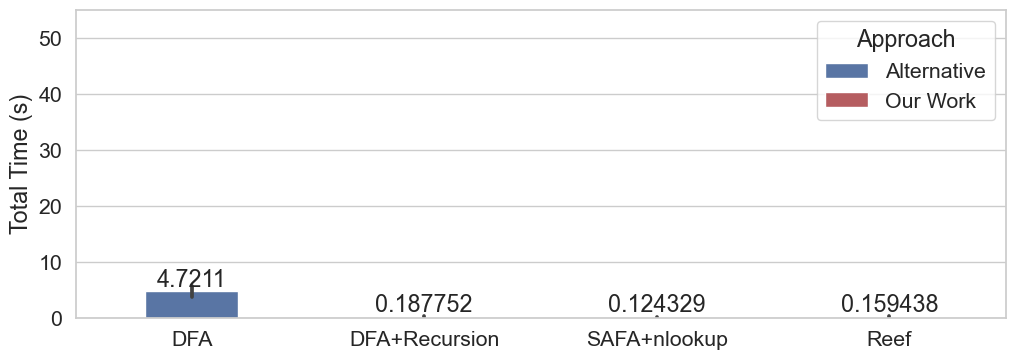

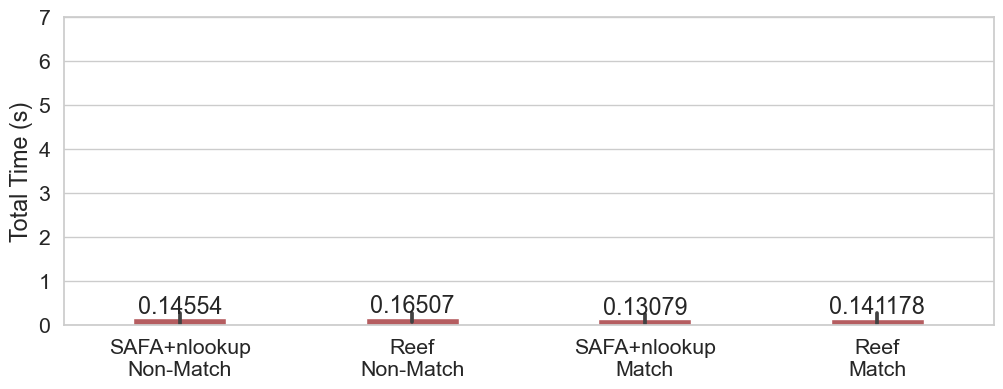

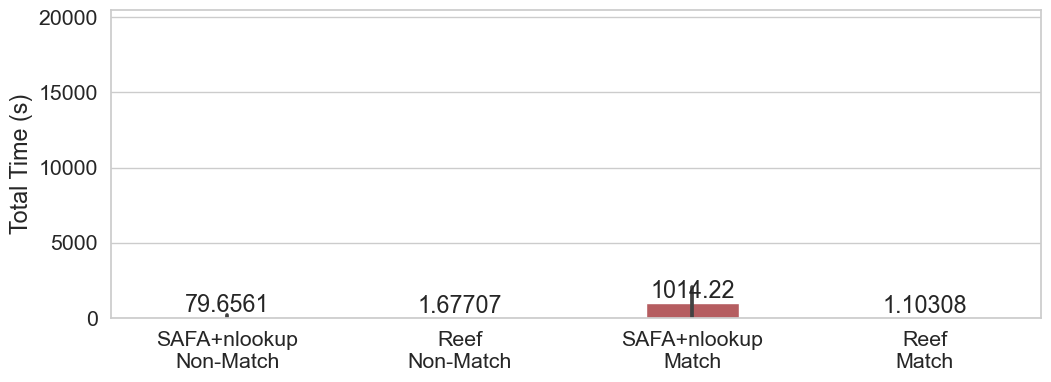

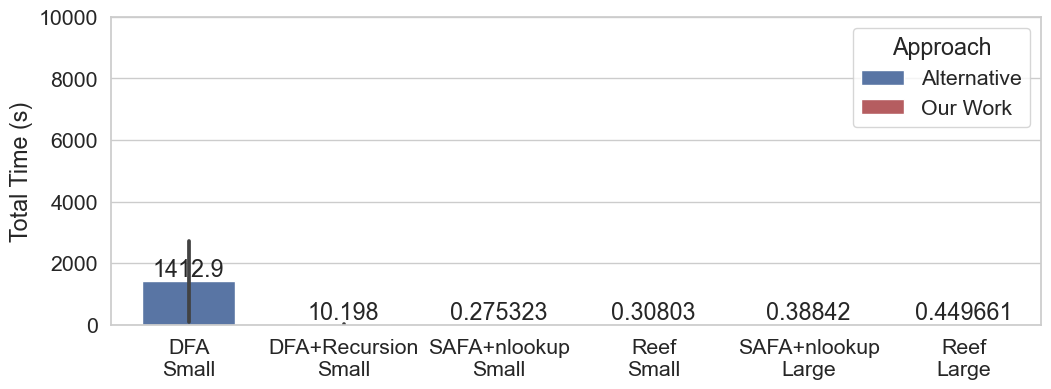

In [17]:
plt.rcParams.update({'font.size': 16})
a4_dims = (12, 4)
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
order_list = ['DFA','DFA+Recursion','SAFA+nlookup','Reef']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=t.loc[t.app=='pihole'],x='label',y='val',
                 hue='Approach',palette={"Our Work":"C3","Alternative":"C0"},order=order_list,dodge=False,width=.4)
ax.set(ylabel='Total Time (s)')
# ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,)
ax.set_ylim(0,55)
# wrap_labels(ax,5)
plt.savefig("odoh.pdf", bbox_inches='tight')

order_list = ['SAFA+nlookup\nNon-Match','Reef\nNon-Match','SAFA+nlookup\nMatch','Reef\nMatch']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=t.loc[t.app.str.contains('pass')],x='label',y='val',
                 hue='Approach',palette={"Our Work":"C3","Alternative":"C0"},order=order_list,dodge=False,
                width=.4)
ax.set(ylabel='Total Time (s)')
ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,)
# wrap_labels(ax,10)
ax.set_ylim(0,7)
plt.savefig("password.pdf", bbox_inches='tight')

order_list = ['SAFA+nlookup\nNon-Match','Reef\nNon-Match','SAFA+nlookup\nMatch','Reef\nMatch']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=t.loc[t.app.str.contains('brca')],x='label',y='val',hue='Approach',palette={"Our Work":"C3","Alternative":"C0"},
                 order=order_list,
                dodge=False,width=.4)
ax.set(ylabel='Total Time (s)')
ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,)
# wrap_labels(ax,10)
ax.set_ylim(0,20500)
plt.savefig("dna.pdf", bbox_inches='tight')

order_list = ['DFA\nSmall','DFA+Recursion\nSmall','SAFA+nlookup\nSmall','Reef\nSmall',
              'SAFA+nlookup\nLarge','Reef\nLarge']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=t.loc[t.app.str.contains('email')],x='label',y='val',hue='Approach',
                 palette={"Our Work":"C3","Alternative":"C0"},order=order_list,
                dodge=False,width=.6)
ax.set(ylabel='Total Time (s)')
# ax.legend().texts[0].set_text("")
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,)
# wrap_labels(ax,3)
ax.set_ylim(0,10000)
plt.savefig("email.pdf", bbox_inches='tight')

In [58]:
def comp_formating(app): 
    if app=='P':
        return "Proving"
    else:
        return "Solving"

In [62]:
b = ((graph_sub_df.groupby(['app','setup','hash_id','time','component']).val.sum().reset_index()).groupby([
    'app','setup','hash_id','component']).val.mean()/1e6).reset_index()
b['label'] = b.apply(lambda x: label_formating(x.setup,x.app,x.hash_id), axis = 1)
b["Component"] = b.apply(lambda x: comp_formating(x.component),axis=1)
b.reset_index(inplace=True)

In [63]:
b

,index,app,setup,hash_id,component,val,label,Component
0,0,bad_pass,reef,304b5,P,3.315359,Reef\nNon-Match,Proving
1,1,bad_pass,reef,304b5,S,0.377019,Reef\nNon-Match,Solving
2,2,bad_pass,safa+nlookup,304b5,P,2.624299,SAFA+nlookup\nNon-Match,Proving
3,3,bad_pass,safa+nlookup,304b5,S,0.200557,SAFA+nlookup\nNon-Match,Solving
4,4,brca2_var1_match,reef,e5e5b,P,18.384234,Reef\nMatch,Proving
5,5,brca2_var1_match,reef,e5e5b,S,8.037026,Reef\nMatch,Solving
6,6,brca2_var1_match,safa+nlookup,e5e5b,P,21.529023,SAFA+nlookup\nMatch,Proving
7,7,brca2_var1_match,safa+nlookup,e5e5b,S,18242.136865,SAFA+nlookup\nMatch,Solving
8,8,brca2_var1_nonmatch,reef,95a42,P,12.590398,Reef\nNon-Match,Proving
9,9,brca2_var1_nonmatch,reef,95a42,S,3.111041,Reef\nNon-Match,Solving


/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/elizabethmargolin/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

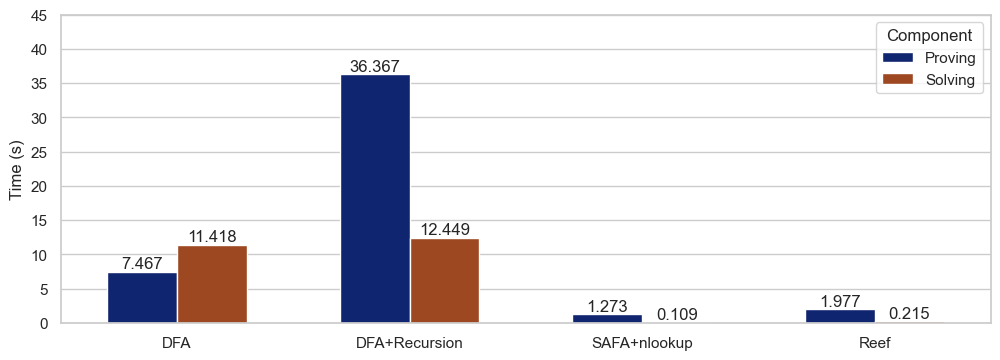

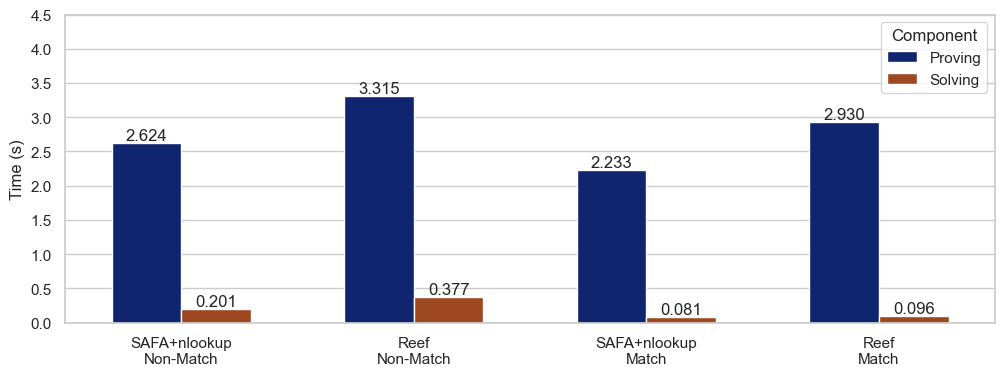

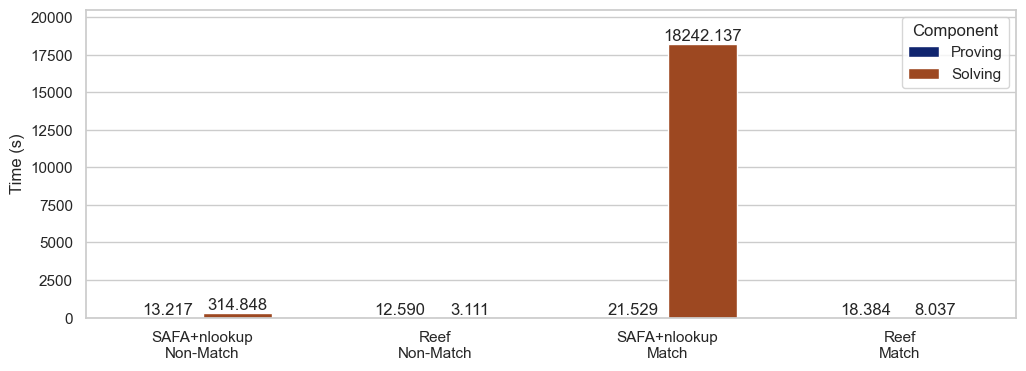

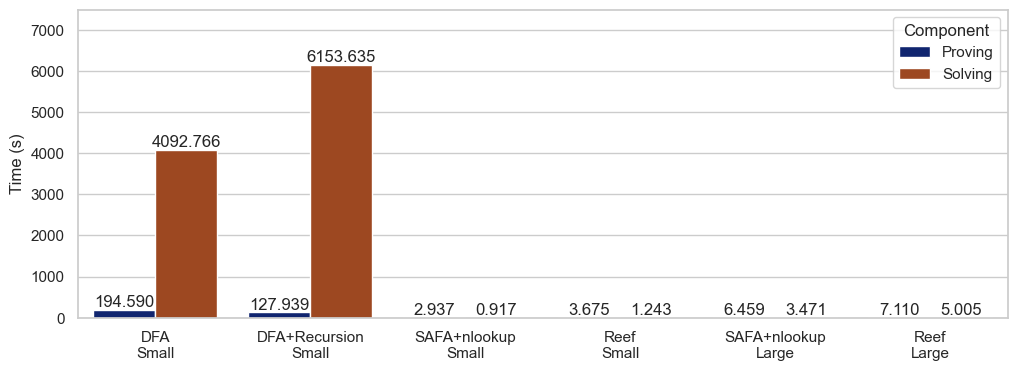

In [80]:
plt.rcParams.update({'font.size': 18})
a4_dims = (12, 4)
sns.set(font_scale=1)
sns.set_style("whitegrid")
order_list = ['DFA','DFA+Recursion','SAFA+nlookup','Reef']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=b.loc[b.app=='pihole'],x='label',y='val',hue="Component",palette="dark",order=order_list,
                width=.6)
ax.set(ylabel='Time (s)')
# ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')
ax.set_ylim(0,45)
# wrap_labels(ax,5)
plt.savefig("odoh_split.pdf", bbox_inches='tight')

order_list = ['SAFA+nlookup\nNon-Match','Reef\nNon-Match','SAFA+nlookup\nMatch','Reef\nMatch']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=b.loc[b.app.str.contains('pass')],x='label',y='val',
                 hue='Component',palette="dark",order=order_list,width=.6)
ax.set(ylabel='Time (s)')
# ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')
# wrap_labels(ax,10)
ax.set_ylim(0,4.5)
plt.savefig("password_split.pdf", bbox_inches='tight')

order_list = ['SAFA+nlookup\nNon-Match','Reef\nNon-Match','SAFA+nlookup\nMatch','Reef\nMatch']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=b.loc[b.app.str.contains('brca')],x='label',y='val',
                 hue='Component',palette="dark",order=order_list,width=.6)
ax.set(ylabel='Time (s)')
# ax.legend([],[],frameon=False)
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')
# wrap_labels(ax,10)
ax.set_ylim(0,20500)
plt.savefig("dna_split.pdf", bbox_inches='tight')

order_list = ['DFA\nSmall','DFA+Recursion\nSmall','SAFA+nlookup\nSmall','Reef\nSmall',
              'SAFA+nlookup\nLarge','Reef\nLarge']
plt.figure(figsize=a4_dims)
ax = sns.barplot(data=b.loc[b.app.str.contains('email')],x='label',y='val',
                 hue='Component',palette="dark",order=order_list,width=.8)
ax.set(ylabel='Time (s)')
# ax.legend().texts[0].set_text("")
ax.set(xlabel=None)
for i in ax.containers:
    ax.bar_label(i,fmt='%.3f')
# wrap_labels(ax,3)
ax.set_ylim(0,7500)
plt.savefig("email_split.pdf", bbox_inches='tight')